### Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


<img src="fb_logo_rect.jpg">

## Introduction

In this notebook, we will be examining data from house sales in King County, Washington in order to determine what a potential seller may be able to do in order to increase the final sale price of their home.  While there are many factors at play when it comes to home value, we will attempt to figure out key features that drive sale price using data scrubbing and linear regression models.  

In this notebook, we will attempt to answer three important questions:
  - What are the three most important features to consider in regards to sale price?
  - How much does each feature affect the overall sale price? 
  - A third question I haven't thought of yet.  

### Importing Packages

In [1]:
# !pip install missingno
# !pip install mlxtend

In [2]:
# Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as ms

#for feature engineering
from sklearn.preprocessing import StandardScaler

# for modeling
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Functions

In [3]:
def df_info(df):
    # gets shape, describe and info for datasets
    return df.shape, df.describe(), df.info()

def scatter_plot_exploration(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = df[col], y = df['price'])
    ax.set_title('{} vs. Price'.format(col), fontsize = 20)
    ax.set_xlabel('{}'.format(col), fontsize = 16)
    ax.set_ylabel('Sale Price', fontsize = 16);

def plot_col(df, col, target = 'price'):
    g = sns.jointplot(data = df, x = col, y = target, kind = 'reg')
    plt.suptitle(f"{col} vs. {target}");
    return g

def outliers_range_iqr(df, column, distance = 1.5):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    lower_threshold = df[column].quantile(0.25) - (iqr * distance)
    upper_threshold = df[column].quantile(0.75) + (iqr * distance)
    return lower_threshold, upper_threshold

def find_outliers_iqr(df, column):
    lower_threshold, upper_threshold = outliers_range_iqr(df, column)
    outliers = []
    for i in df[column]:
        if i > upper_threshold:
            outliers.append(i)
        elif i < lower_threshold:
            outliers.append(i)
        else: 
            pass
    return outliers

def remove_outliers_iqr(df, column):
    outliers = find_outliers_iqr(df, column)
    outliers = pd.Series(outliers)
    df_new = df[~df[column].isin(outliers)]
    return df_new

def check_normality(x, y):
    fix, axes = plt.subplots(cols = 2, figsize = (10, 6))
    sns.distplot(x, ax = axes[0], kde = False, bins = 'auto')
    axes[0].set(label = 'X')
    sns.distplot(y, ax = axes[1], kde = False, bins = 'auto')
    axes[1].set(label = 'Y')
    x_normal = stats.normaltest(x)
    print(x_normal)
    y_normal = stats.normaltest(y)
    print(y_normal)
    
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

def heatmap(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (16,12))
    sns.set(style = 'white')
    sns.heatmap(corr, mask = mask, cmap="Blues", annot = True);
    
def diagnostic_plots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    df[column].hist(bins = 30)
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist = 'norm', plot = plt)
    plt.title('{}'.format(column))
    plt.show()
    
def scatter_box_plots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.regplot(data = df, x = column, y = 'price', fit_reg = True)
    plt.title('{}'.format(column))
    plt.subplot(1,2,2)
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

## Obtain


### Import Data

In [4]:
# Loading and previewing the dataset

df = pd.read_csv('kc_house_data.csv')
pd.set_option('display.max_columns', 0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Exploratory Visualizations - MOVE TO EXPLORE SECTION

#### Scatter Plots

In [5]:
# for col in df.columns:
#     scatter_plot_exploration(col)

#### Reg Plots

In [6]:
# for col in df.columns:
#     plot_col(df, col)

## Scrub

##### Column Descriptions
Below are the column descriptions that were given along with the dataset.  

- id - A notation for a house
- date - Date house was sold
- price - Price is prediction target
- bedrooms Number of Bedrooms/House
- bathrooms - Number of bathrooms/bedrooms
- sqft_living - Square footage of the home
- sqft_lot - Square footage of the lot
- floors - Total floors (levels) in house
- waterfront - House which has a view to a waterfront
- view - Has been viewed
- condition - How good the condition is ( Overall )
- grade - Overall grade given to the housing unit, based on King County grading system
- sqft_above - square footage of house apart from basement
- sqft_basement - square footage of the basement
- yr_built - Built Year
- yr_renovated - Year when house was renovated
- zipcode - Zipcode
- lat - Latitude coordinate
- long - Longitude coordinate
- sqft_living15 - Living room area in 2015 (implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15 - Lot size area in 2015 (implies-- some renovations)

In [7]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [8]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

((21597, 21),
                  id         price  ...  sqft_living15     sqft_lot15
 count  2.159700e+04  2.159700e+04  ...   21597.000000   21597.000000
 mean   4.580474e+09  5.402966e+05  ...    1986.620318   12758.283512
 std    2.876736e+09  3.673681e+05  ...     685.230472   27274.441950
 min    1.000102e+06  7.800000e+04  ...     399.000000     651.000000
 25%    2.123049e+09  3.220000e+05  ...    1490.000000    5100.000000
 50%    3.904930e+09  4.500000e+05  ...    1840.000000    7620.000000
 75%    7.308900e+09  6.450000e+05  ...    2360.000000   10083.000000
 max    9.900000e+09  7.700000e+06  ...    6210.000000  871200.000000
 
 [8 rows x 19 columns],
 None)

Seems to be some weirdness in here with the datatypes.  We can explore this further later on.  For now, we can drop the id column as it's just meant to be an identifier. 

In [9]:
# Dropping the id column 

df.drop(['id'], axis = 1, inplace = True)

### Dealing with sqft_basement column

In [10]:
# Checking the value counts of sqft_basement.

df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1248.0        1
506.0         1
2400.0        1
2180.0        1
417.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [11]:
# Replacing the ? with nan's and changing the dtype from string to float. 

df['sqft_basement'].replace('?', np.nan, inplace = True) 
df['sqft_basement'] = df['sqft_basement'].astype('float') 

### Dealing with the Date & Year Columns

#### Date Column to Datetime

In [12]:
df['date'] = pd.to_datetime(df['date']) # convert date column from string to datetime

In [13]:
df['sales_year'] = df['date'].dt.year


In [14]:
df['sales_month'] = df['date'].dt.month # create a column show month of sale

In [15]:
df['sales_day'] = df['date'].dt.dayofweek # create a column to show day of sale

In [16]:
df.drop(['date'], axis = 1, inplace = True) # dropping date column

In [17]:
 # checking to see how the values relate to the days.  According to docstring - 0 = Monday, 1 = Tuesday, etc.

df['sales_day'].unique()

array([0, 1, 2, 4, 3, 5, 6])

#### Year Column Transformation 
Year columns are yr_built & yr_renovated

In [18]:
type(df['sales_year'][1])

numpy.int64

In [19]:
# Create a house age column 

df['house_age'] = df['sales_year'] - df['yr_built']

In [20]:
df.drop(['sales_year', 'yr_built'], axis = 1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,0.0,98178,47.5112,-122.257,1340,5650,10,0,59
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1991.0,98125,47.7210,-122.319,1690,7639,12,1,63
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,NaN,98028,47.7379,-122.233,2720,8062,2,2,82
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,0.0,98136,47.5208,-122.393,1360,5000,12,1,49
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,0.0,98074,47.6168,-122.045,1800,7503,2,2,28


In [21]:
# deal with null values in yr_renovated & change from float to int

df['yr_renovated'].mode() # mode = 0.0
df['yr_renovated'].fillna(0.0, axis = 0, inplace = True)
df['yr_renovated'] = df['yr_renovated'].astype('int') 
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,0,98178,47.5112,-122.257,1340,5650,10,0,59
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1991,98125,47.7210,-122.319,1690,7639,12,1,63
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,0,98028,47.7379,-122.233,2720,8062,2,2,82
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,0,98136,47.5208,-122.393,1360,5000,12,1,49
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,0,98074,47.6168,-122.045,1800,7503,2,2,28


In [22]:
df['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
        ...  
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

Since there's so many 0 values in here, it would make sense to transform this column into a 'was_renovated' (1,0)

In [23]:
# Change the column to a boolean

for i in df['yr_renovated']:
    if i > 0:
        df['yr_renovated'].replace(i, 1, inplace = True)

# Change column name
df['was_renovated'] = df['yr_renovated']
df.drop(['yr_renovated'], axis = 1, inplace = True)

print(df['was_renovated'].value_counts())
df.head()

0    20853
1      744
Name: was_renovated, dtype: int64


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,10,0,59,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,12,1,63,1
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,2,2,82,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,12,1,49,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,2,2,28,0


### Dealing with Remaining Null Values

In [24]:
# Let's preview the mildly edited dataframe again

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,10,0,59,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,12,1,63,1
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,2,2,82,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,12,1,49,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,2,2,28,0


In [25]:
print(df.shape)  # shape for reference
df.isna().sum()  # checking for null values

(21597, 21)


price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     454
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
sales_month         0
sales_day           0
house_age           0
was_renovated       0
dtype: int64

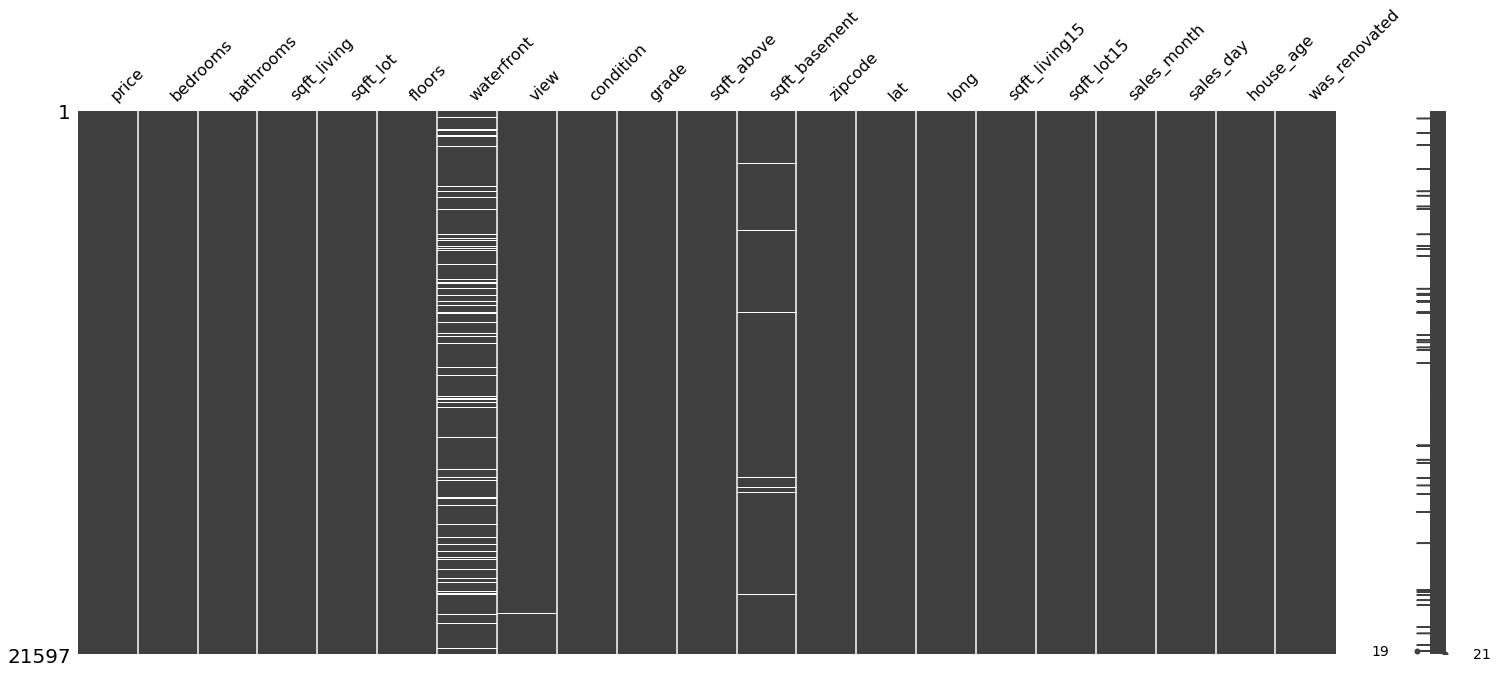

In [26]:

ms.matrix(df);

In [27]:
# Replace nan's in watefront with the mode & change type to integer.

df['waterfront'].mode() # mode = 0.0
df['waterfront'].fillna(0.0, axis = 0, inplace = True)
df['waterfront'] = df['waterfront'].astype(int)

In [28]:
# Replace nan's in view with the mode & change type to integer.

df['view'].mode() # mode = 0.0
df['view'].fillna(0.0, axis = 0, inplace = True)
df['view'] = df['view'].astype(int)

In [29]:
# Replace nan's in sqft_basement.  Both median and mode are the same so for fun, let's do the median.

df['sqft_basement'].median()  # median = 0.0
df['sqft_basement'].fillna(0.0, axis = 0, inplace = True)

In [30]:
# Let's make sure the null values are all taken care of.

df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sales_month      0
sales_day        0
house_age        0
was_renovated    0
dtype: int64

#### Model 1 = Remove Before Final
Just to see where we're at thus far, we'll run a baseline linear regression model with Statsmodels OLS.  

In [31]:
# run a statsmodels ols linear regression model 

features = '+'.join(df.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2528.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:31   Log-Likelihood:            -2.9436e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21576   BIC:                         5.889e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.487e+06   2.88e+06      0.516      0.606   -4.16e+06    7.13e+06
bedrooms      -3.606e+04   1898.374    -18.993      0.000   -3.98e+04   -3.23e+04
bathrooms      4.172e+04   3258.690     12.804      0.000    3.53e+04    4.81e+04
sqft_living     102.4171     18.054      5.673      0.000      67.031     137.804
sqft_lot          0.1254      0.048      2.621      0.009       0.032       0.219
floors         7505.9908   3596.657      2.087      0.037     456.276    1.46e+04
waterfront     6.193e+05   1.81e+04     34.188      0.000    5.84e+05    6.55e+05
view           5.306e+04   2119.655     25.033      0.000    4.89e+04    5.72e+04
condition      2.721e+04   2343.511     11.612      0.000    2.26e+04    3.18e+04
grade          9.699e+04   2157.940     44.944      0.000    9.28e+04    1.01e+05
sqft_above       78.6412     18.045      4.358      0.000      43.272     114.010
sqft_basement    48.3589     17.884      2.704      0.007      13.304      83.414
zipcode        -586.5578     32.952    -17.801      0.000    -651.145    -521.970
lat            6.015e+05   1.07e+04     56.077      0.000     5.8e+05    6.22e+05
long           -2.18e+05   1.31e+04    -16.591      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.3689      3.446      6.201      0.000      14.614      28.124
sqft_lot15       -0.3834      0.073     -5.234      0.000      -0.527      -0.240
sales_month   -2778.3394    440.079     -6.313      0.000   -3640.927   -1915.752
sales_day      -180.4799    937.878     -0.192      0.847   -2018.790    1657.830
house_age      2648.0808     71.830     36.866      0.000    2507.288    2788.874
was_renovated  4.684e+04   7927.620      5.908      0.000    3.13e+04    6.24e+04
==============================================================================
Omnibus:                    18374.162   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1854524.032
Skew:                           3.570   Prob(JB):                         0.00
Kurtosis:                      47.832   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 864x432 with 0 Axes>

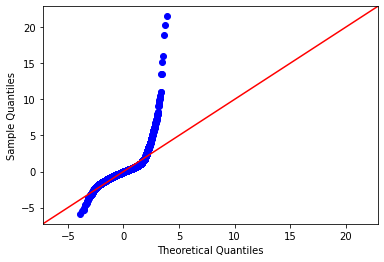

In [32]:
fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

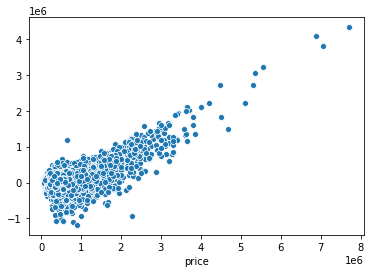

In [33]:
sns.scatterplot(df['price'], model.resid);

## Explore

### Initial Exploration
Now that we have at least a "clean" dataframe, let's see what additional scrubbing info we can pull out of it.  

In [34]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,10,0,59,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,12,1,63,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,2,2,82,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,12,1,49,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,2,2,28,0


In [35]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  zipcode        21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
 15  sqft_living15  21597 non-null  int64  
 16  sqft_lot15     21597 non-null  int64  
 17  sales_month    21597 non-null  int64  
 18  sales_

((21597, 21),
               price      bedrooms  ...     house_age  was_renovated
 count  2.159700e+04  21597.000000  ...  21597.000000   21597.000000
 mean   5.402966e+05      3.373200  ...     43.323286       0.034449
 std    3.673681e+05      0.926299  ...     29.377285       0.182384
 min    7.800000e+04      1.000000  ...     -1.000000       0.000000
 25%    3.220000e+05      3.000000  ...     18.000000       0.000000
 50%    4.500000e+05      3.000000  ...     40.000000       0.000000
 75%    6.450000e+05      4.000000  ...     63.000000       0.000000
 max    7.700000e+06     33.000000  ...    115.000000       1.000000
 
 [8 rows x 21 columns],
 None)

In [36]:
# Let's see what these columns look like 

# for column in df.columns:
#     diagnostic_plots(df, column)

In [37]:
# Let's see scatter and box plots for all columns 

# for column in df.columns:
#     scatter_box_plots(df, column)

In [38]:
# Checking the value counts on the weird looking box plots

check_unique_cols = ['sqft_lot','waterfront','view', 'was_renovated', 'sqft_lot15']
for col in check_unique_cols:
    print('Column: {}'.format(df[col].value_counts()))

Column: 5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
Column: 0    21451
1      146
Name: waterfront, dtype: int64
Column: 0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64
Column: 0    20853
1      744
Name: was_renovated, dtype: int64
Column: 5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64


Lots of outlier issues here and these can be addressed on a case to case basis. Before that, we're seeing that waterfront, view & was_renovated don't offer much relevent info and can probably be dropped.

In [39]:
# dropping the irrelevant columns

df.drop(['waterfront', 'view', 'was_renovated'], axis = 1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,10,0,59
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,12,1,63
2,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,2,2,82
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,12,1,49
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,2,2,28


#### Model 2 - Remove before Final

In [40]:
features = '+'.join(df.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2483.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:32   Log-Likelihood:            -2.9569e+05
No. Observations:               21597   AIC:                         5.914e+05
Df Residuals:                   21579   BIC:                         5.916e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.725e+06   3.04e+06     -3.200      0.001   -1.57e+07   -3.77e+06
bedrooms      -4.679e+04   2005.919    -23.328      0.000   -5.07e+04   -4.29e+04
bathrooms       4.75e+04   3439.425     13.810      0.000    4.08e+04    5.42e+04
sqft_living     125.4076     19.186      6.537      0.000      87.802     163.013
sqft_lot          0.1482      0.051      2.913      0.004       0.048       0.248
floors         1.315e+04   3819.344      3.444      0.001    5665.766    2.06e+04
condition      2.628e+04   2462.147     10.672      0.000    2.14e+04    3.11e+04
grade          1.032e+05   2285.398     45.143      0.000    9.87e+04    1.08e+05
sqft_above       61.9244     19.175      3.229      0.001      24.341      99.508
sqft_basement    55.5802     19.017      2.923      0.003      18.305      92.855
zipcode        -487.0741     34.887    -13.961      0.000    -555.456    -418.693
lat            5.512e+05   1.13e+04     48.622      0.000    5.29e+05    5.73e+05
long          -2.488e+05   1.39e+04    -17.839      0.000   -2.76e+05   -2.21e+05
sqft_living15    37.8791      3.614     10.480      0.000      30.795      44.964
sqft_lot15       -0.3171      0.078     -4.070      0.000      -0.470      -0.164
sales_month   -2743.8698    467.905     -5.864      0.000   -3660.998   -1826.742
sales_day      -227.8229    997.279     -0.228      0.819   -2182.564    1726.918
house_age      3075.8063     72.777     42.263      0.000    2933.158    3218.455
==============================================================================
Omnibus:                    19504.185   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1950209.824
Skew:                           3.959   Prob(JB):                         0.00
Kurtosis:                      48.875   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 864x432 with 0 Axes>

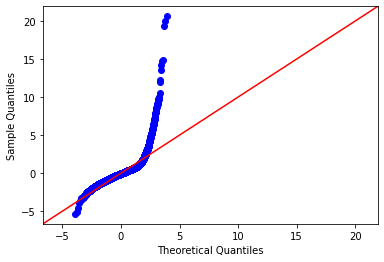

In [41]:
fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

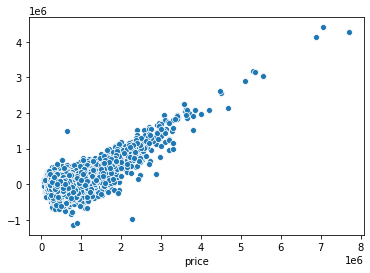

In [42]:
sns.scatterplot(df['price'], model.resid);

### Are there any outliers that may affect our model?
Let's face it...most likely.  Let's see just how bad it is.  

In [43]:
# Let's check out some boxplots as well

# for column in df.columns:
#     plt.figure(figsize = (8,4))
#     sns.boxplot(df[column])
#     plt.title('{}'.format(column))
#     plt.show()

In [44]:
df.shape

(21597, 18)

In [45]:
# Finding and removing outliers with a series of functions

for column in df.columns:
    df = remove_outliers_iqr(df, column)

df.shape

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(15311, 18)

In [46]:
# for column in df.columns:
#     diagnostic_plots(df, column)

In [47]:
# for column in df.columns:
#     scatter_box_plots(df, column)

In [48]:
# Second round of outlier removal using the same method

for column in df.columns:
    df = remove_outliers_iqr(df, column)

df.shape

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(14346, 18)

In [49]:
# for column in df.columns:
#     diagnostic_plots(df, column)

In [50]:
# for column in df.columns:
#     scatter_box_plots(df, column)

#### Model 3 - Remove before Final

In [51]:
features = '+'.join(df.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1499.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:34   Log-Likelihood:            -1.8563e+05
No. Observations:               14346   AIC:                         3.713e+05
Df Residuals:                   14328   BIC:                         3.714e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.743e+06   1.79e+06     -1.533      0.125   -6.25e+06    7.64e+05
bedrooms      -1.025e+04   1429.880     -7.168      0.000   -1.31e+04   -7446.458
bathrooms      1.793e+04   2186.939      8.200      0.000    1.36e+04    2.22e+04
sqft_living      95.3384     13.279      7.180      0.000      69.310     121.367
sqft_lot         -3.0826      0.643     -4.793      0.000      -4.343      -1.822
floors         5639.7217   2565.820      2.198      0.028     610.382    1.07e+04
condition      2.346e+04   1427.838     16.432      0.000    2.07e+04    2.63e+04
grade          7.319e+04   1621.657     45.134      0.000       7e+04    7.64e+04
sqft_above      -10.3666     13.273     -0.781      0.435     -36.383      15.650
sqft_basement    -7.7780     13.120     -0.593      0.553     -33.495      17.939
zipcode        -230.1428     20.875    -11.025      0.000    -271.061    -189.225
lat            5.135e+05   6518.085     78.780      0.000    5.01e+05    5.26e+05
long          -3648.4019   1.03e+04     -0.354      0.723   -2.39e+04    1.66e+04
sqft_living15    55.5487      2.848     19.504      0.000      49.966      61.131
sqft_lot15       -7.0459      0.694    -10.159      0.000      -8.405      -5.686
sales_month   -1991.5287    269.840     -7.380      0.000   -2520.450   -1462.607
sales_day       137.1780    576.632      0.238      0.812    -993.095    1267.451
house_age      1932.7578     43.571     44.359      0.000    1847.352    2018.163
==============================================================================
Omnibus:                      983.288   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1564.634
Skew:                           0.547   Prob(JB):                         0.00
Kurtosis:                       4.191   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 864x432 with 0 Axes>

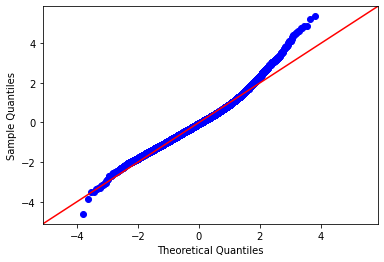

In [52]:
fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

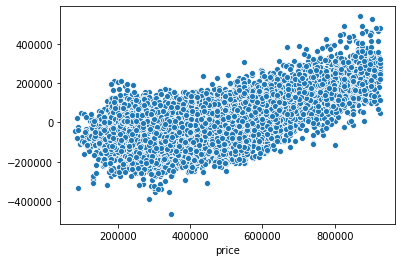

In [53]:
sns.scatterplot(df['price'], model.resid);

### Could any of the columns be categorical?

Thus far, all of the columns represent numerical data.  Let's investigate whether or not any of these could actually be categorical. After checking out the plots above, it seems as though the following columns could actually be categorical: <b> floors, waterfront, view, and was_renovated. </b>

In [54]:
# Changing the datatypes  --- This might have become an irrelevant cell after shifting things around

# df['floors'] = df['floors'].astype('object')
# df['waterfront'] = df['waterfront'].astype('object')
# df['view'] = df['view'].astype('object')
# df['was_renovated'] = df['was_renovated'].astype('object')
# df.info()

Zipcode should definitely be converted into an object as it's a category and not a numerical value. 

In [55]:
# Changing zipcode to an object

df['zipcode'] = df['zipcode'].astype('object') 

In [56]:
# Separating Categorical and Numerical columns for future use

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

print('Categorical Columns: {}'.format(str(cat_cols)))
print('Numerical Columns: {}'.format(str(num_cols)) )

Categorical Columns: ['zipcode']
Numerical Columns: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_month', 'sales_day', 'house_age']


In [57]:
#one-hot encoding for category columns

df_dummies = df.copy()
df_dummies = pd.get_dummies(df, columns = cat_cols, drop_first = True)
print(df_dummies.shape)
df_dummies.head()

(14346, 84)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,...,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,47.5112,-122.257,1340,5650,10,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,47.7210,-122.319,1690,7639,12,1,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,47.7379,-122.233,2720,8062,2,2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,47.5208,-122.393,1360,5000,12,1,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,47.6168,-122.045,1800,7503,2,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Model 4 - Remove before Final

In [58]:
features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     724.7
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:35   Log-Likelihood:            -1.8111e+05
No. Observations:               14346   AIC:                         3.624e+05
Df Residuals:                   14262   BIC:                         3.630e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.709e+06   5.23e+06      1.091      0.275   -4.55e+06     1.6e+07
bedrooms      -3958.5140   1062.808     -3.725      0.000   -6041.756   -1875.272
bathrooms      1.216e+04   1609.961      7.554      0.000    9005.745    1.53e+04
sqft_living      78.6403      9.745      8.070      0.000      59.538      97.742
sqft_lot          1.8899      0.476      3.971      0.000       0.957       2.823
floors        -1.292e+04   1952.676     -6.615      0.000   -1.67e+04   -9089.298
condition      2.126e+04   1071.686     19.840      0.000    1.92e+04    2.34e+04
grade           4.03e+04   1262.430     31.919      0.000    3.78e+04    4.28e+04
sqft_above       38.2180      9.759      3.916      0.000      19.089      57.347
sqft_basement     1.0601      9.621      0.110      0.912     -17.798      19.918
lat           -5842.6568   4.03e+04     -0.145      0.885   -8.48e+04    7.31e+04
long           4.756e+04   4.15e+04      1.146      0.252   -3.38e+04    1.29e+05
sqft_living15    38.7413      2.149     18.025      0.000      34.528      42.954
sqft_lot15       -0.4823      0.537     -0.898      0.369      -1.535       0.570
sales_month   -2335.3024    197.898    -11.801      0.000   -2723.208   -1947.396
sales_day       242.4126    422.815      0.573      0.566    -586.361    1071.186
house_age       622.6972     36.279     17.164      0.000     551.586     693.808
zipcode_98002  5272.8423   7829.981      0.673      0.501   -1.01e+04    2.06e+04
zipcode_98003  4773.2751   7043.960      0.678      0.498   -9033.806    1.86e+04
zipcode_98004  4.758e+05   1.59e+04     29.991      0.000    4.45e+05    5.07e+05
zipcode_98005  3.078e+05    1.6e+04     19.198      0.000    2.76e+05    3.39e+05
zipcode_98006   2.37e+05   1.35e+04     17.559      0.000    2.11e+05    2.63e+05
zipcode_98007  2.332e+05   1.62e+04     14.367      0.000    2.01e+05    2.65e+05
zipcode_98008  2.298e+05   1.59e+04     14.407      0.000    1.99e+05    2.61e+05
zipcode_98010   4.12e+04   1.78e+04      2.311      0.021    6250.477    7.61e+04
zipcode_98011   1.44e+05   1.99e+04      7.227      0.000    1.05e+05    1.83e+05
zipcode_98014  1.428e+05   3.39e+04      4.211      0.000    7.63e+04    2.09e+05
zipcode_98019  8.339e+04   2.37e+04      3.513      0.000    3.69e+04     1.3e+05
zipcode_98022 -4091.7368   1.42e+04     -0.288      0.773   -3.19e+04    2.38e+04
zipcode_98023 -8623.6059   7272.820     -1.186      0.236   -2.29e+04    5632.069
zipcode_98024   1.07e+05   4.12e+04      2.598      0.009    2.63e+04    1.88e+05
zipcode_98027  2.154e+05   1.54e+04     13.998      0.000    1.85e+05    2.46e+05
zipcode_98028  1.298e+05   1.93e+04      6.714      0.000    9.19e+04    1.68e+05
zipcode_98029  2.188e+05   1.71e+04     12.791      0.000    1.85e+05    2.52e+05
zipcode_98030  2113.6830   8180.622      0.258   

<Figure size 864x432 with 0 Axes>

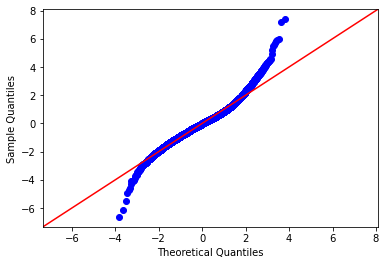

In [59]:
fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

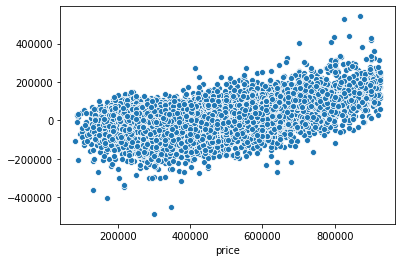

In [60]:
sns.scatterplot(df_dummies['price'], model.resid);

### Are there any multicolinearity issues?

In [61]:
# super helpful

# heatmap(df_dummies)

The heatmap wasn't super helpful but the previous model had a warning indicating that there were, indeed, issues with multicolinearity.  We'll have to run feature selection methods to remove this issue.  First, we'll deal with correlated features and then give a Lasso feature selection a shot.  

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [63]:
# check for correlation first

def correlation(df, threshold):
    col_corr = set() # set of corellated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

In [64]:
# pull out correlated features

corr_features = correlation(df_dummies, 0.8)
corr_features

{'sqft_lot15'}

In [65]:
df_dummies.drop(labels = corr_features, axis = 1, inplace = True)
df_dummies

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sales_month,sales_day,house_age,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,...,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,47.5112,-122.257,1340,10,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,47.7210,-122.319,1690,12,1,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,47.7379,-122.233,2720,2,2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,47.5208,-122.393,1360,12,1,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,47.6168,-122.045,1800,2,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,3,8,1530,0.0,47.6993,-122.346,1530,5,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.0,4,2.50,2310,5813,2.0,3,8,2310,0.0,47.5107,-122.362,1830,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21594,402101.0,2,0.75,1020,1350,2.0,3,7,1020,0.0,47.5944,-122.299,1020,6,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21595,400000.0,3,2.50,1600,2388,2.0,3,8,1600,0.0,47.5345,-122.069,1410,1,4,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
# Let's see about VIF for multicolinearity

In [67]:
x = df_dummies.drop('price', axis = 1)
x = sm.add_constant(x)
vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif_results = pd.Series(dict(zip(x.columns, vif)))
vif_results

const            7.228402e+07
bedrooms         1.697118e+00
bathrooms        2.820022e+00
sqft_living      6.921862e+01
sqft_lot         2.396141e+00
                     ...     
zipcode_98177    1.037234e+01
zipcode_98178    4.334158e+00
zipcode_98188    2.038283e+00
zipcode_98198    2.422171e+00
zipcode_98199    9.555607e+00
Length: 83, dtype: float64

In [68]:
threshold = 6
bad_vif = list(vif_results[vif_results > threshold].index)
if 'const' in bad_vif:
    bad_vif.remove('const')
bad_vif

['sqft_living',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'zipcode_98006',
 'zipcode_98008',
 'zipcode_98011',
 'zipcode_98019',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98056',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98122',
 'zipcode_98125',
 'zipcode_98126',
 'zipcode_98133',
 'zipcode_98144',
 'zipcode_98155',
 'zipcode_98177',
 'zipcode_98199']

In [69]:
# Best practice is to keep the zipcode columns intact for now so let's remove the others

df_dummies.drop(['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long' ], axis = 1, inplace = True)
df_dummies

,price,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_living15,sales_month,sales_day,house_age,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,5650,1.0,3,7,1340,10,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,7242,2.0,3,7,1690,12,1,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,10000,1.0,3,6,2720,2,2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,5000,1.0,5,7,1360,12,1,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,8080,1.0,3,8,1800,2,2,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1131,3.0,3,8,1530,5,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.0,4,2.50,5813,2.0,3,8,1830,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21594,402101.0,2,0.75,1350,2.0,3,7,1020,6,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21595,400000.0,3,2.50,2388,2.0,3,8,1410,1,4,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Remove Quasi-Constant Features

In [70]:
# Filtering out Quasi-Constant Features using the variance threshold.  0.01 should be equivalent to 99%
# Checking out the amount of keepers

sel = VarianceThreshold(threshold = 0.01)
sel.fit(df_dummies)
sum(sel.get_support())

55

In [71]:
# Checking out the keepers

features_to_keep = df_dummies.columns[sel.get_support()]
features_to_keep

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'condition',
       'grade', 'sqft_living15', 'sales_month', 'sales_day', 'house_age',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98006', 'zipcode_98008',
       'zipcode_98023', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98042', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98074', 'zipcode_98092', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98115',
       'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 'zipcode_98122',
       'zipcode_98125', 'zipcode_98126', 'zipcode_98133', 'zipcode_98136',
       'zipcode_98144', 'zipcode_98146', 'zipcode_98155', 'zipcode_98168',
       'zipcode_98177', 'zipcode_98178', 'zipcode_98198', 'zipcode_98199'],
      dtype='object')

In [72]:
# Remove the non-keepers

df_dummies = sel.transform(df_dummies)


In [73]:
# Return to this to a dataframe

df_dummies = pd.DataFrame(df_dummies)
df_dummies.columns = features_to_keep
df_dummies.head()

,price,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_living15,sales_month,sales_day,house_age,zipcode_98002,zipcode_98003,zipcode_98006,zipcode_98008,zipcode_98023,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98042,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98074,zipcode_98092,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98155,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98198,zipcode_98199
0,221900.0,3.0,1.00,5650.0,1.0,3.0,7.0,1340.0,10.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,538000.0,3.0,2.25,7242.0,2.0,3.0,7.0,1690.0,12.0,1.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,2.0,1.00,10000.0,1.0,3.0,6.0,2720.0,2.0,2.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,604000.0,4.0,3.00,5000.0,1.0,5.0,7.0,1360.0,12.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510000.0,3.0,2.00,8080.0,1.0,3.0,8.0,1800.0,2.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Let's see an updated heatmap

# heatmap(df_dummies)

### Baseline Model
Let's throw down a baseline model to see where we're at so far.  

In [75]:
# Running a baseline model 

features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     551.5
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:46   Log-Likelihood:            -1.8488e+05
No. Observations:               14346   AIC:                         3.699e+05
Df Residuals:                   14291   BIC:                         3.703e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -4.91e+05    1.2e+04    -41.068      0.000   -5.14e+05   -4.68e+05
bedrooms       1.049e+04   1259.530      8.327      0.000    8019.097     1.3e+04
bathrooms      4.127e+04   1874.955     22.009      0.000    3.76e+04    4.49e+04
sqft_lot         -2.1256      0.383     -5.553      0.000      -2.876      -1.375
floors         6189.6826   2139.569      2.893      0.004    1995.849    1.04e+04
condition       2.05e+04   1376.461     14.892      0.000    1.78e+04    2.32e+04
grade          7.306e+04   1532.402     47.680      0.000    7.01e+04    7.61e+04
sqft_living15    91.0196      2.511     36.256      0.000      86.099      95.940
sales_month   -1814.4377    256.794     -7.066      0.000   -2317.787   -1311.088
sales_day      -373.2505    548.855     -0.680      0.496   -1449.077     702.576
house_age      1673.4984     43.139     38.793      0.000    1588.940    1758.056
zipcode_98002  -1.46e+05   7721.764    -18.905      0.000   -1.61e+05   -1.31e+05
zipcode_98003 -1.621e+05   6697.228    -24.199      0.000   -1.75e+05   -1.49e+05
zipcode_98006  5.648e+04   7007.882      8.059      0.000    4.27e+04    7.02e+04
zipcode_98008   5.54e+04   6931.629      7.993      0.000    4.18e+04     6.9e+04
zipcode_98023 -1.803e+05   5323.688    -33.872      0.000   -1.91e+05    -1.7e+05
zipcode_98027  4.279e+04   7679.905      5.571      0.000    2.77e+04    5.78e+04
zipcode_98028 -4.364e+04   7227.448     -6.038      0.000   -5.78e+04   -2.95e+04
zipcode_98029  4.031e+04   6665.013      6.047      0.000    2.72e+04    5.34e+04
zipcode_98030 -1.534e+05   6959.186    -22.048      0.000   -1.67e+05    -1.4e+05
zipcode_98031 -1.546e+05   6724.914    -22.986      0.000   -1.68e+05   -1.41e+05
zipcode_98033  1.198e+05   6408.220     18.701      0.000    1.07e+05    1.32e+05
zipcode_98034  1.034e+04   5092.434      2.031      0.042     360.508    2.03e+04
zipcode_98038 -1.133e+05   5302.107    -21.376      0.000   -1.24e+05   -1.03e+05
zipcode_98042 -1.409e+05   5478.668    -25.726      0.000   -1.52e+05    -1.3e+05
zipcode_98052  6.319e+04   5523.685     11.440      0.000    5.24e+04     7.4e+04
zipcode_98053  1.184e+05   7505.232     15.775      0.000    1.04e+05    1.33e+05
zipcode_98055 -1.348e+05   7037.946    -19.150      0.000   -1.49e+05   -1.21e+05
zipcode_98056 -6.531e+04   6131.133    -10.651      0.000   -7.73e+04   -5.33e+04
zipcode_98058 -1.307e+05   5685.839    -22.986      0.000   -1.42e+05    -1.2e+05
zipcode_98059 -7.367e+04   6538.175    -11.267      0.000   -8.65e+04   -6.09e+04
zipcode_98074  3.535e+04   7110.916      4.971      0.000    2.14e+04    4.93e+04
zipcode_98092 -1.832e+05   6817.961    -26.867      0.000   -1.97e+05    -1.7e+05
zipcode_98103  9.555e+04   5030.002     18.995      0.000    8.57e+04    1.05e+05
zipcode_98105  1.134e+05   8402.228     13.491   

In [76]:
# Checking the mean of residuals

model.resid.mean()

-1.8551093953998288e-07

In [77]:
# Figure this function out

def model_diagnostic_plot(residual, target):
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    sm.graphics.qqplot(residual,fit=True, line='45');
    plt.title('QQ-Plot')
    plt.subplot(1,2,2)
    sns.scatterplot(target, residual);
    plt.title('Scatterplot')
    plt.show()

<Figure size 864x432 with 0 Axes>

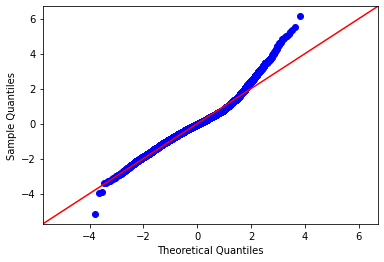

In [78]:
# qqplot to check for linearity 

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

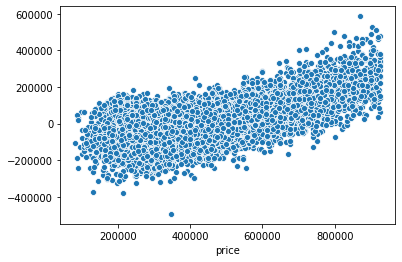

In [79]:
# Scatter plot to check homoscedasticity 

sns.scatterplot(df_dummies['price'], model.resid);

#### Dropping Insignificant Coefficients
Coefficients with p-value's higher than 0.05 are sales_day, zipcode_98125, zipcode_98177

In [80]:
df_dummies.drop(['sales_day', 'zipcode_98125', 'zipcode_98177'], axis = 1, inplace = True)

In [81]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_living15,sales_month,house_age,zipcode_98002,zipcode_98003,zipcode_98006,zipcode_98008,zipcode_98023,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98042,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98074,zipcode_98092,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98122,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98155,zipcode_98168,zipcode_98178,zipcode_98198,zipcode_98199
0,221900.0,3.0,1.00,5650.0,1.0,3.0,7.0,1340.0,10.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,538000.0,3.0,2.25,7242.0,2.0,3.0,7.0,1690.0,12.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,2.0,1.00,10000.0,1.0,3.0,6.0,2720.0,2.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,604000.0,4.0,3.00,5000.0,1.0,5.0,7.0,1360.0,12.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510000.0,3.0,2.00,8080.0,1.0,3.0,8.0,1800.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [82]:
# Separate into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], 
                                                    test_size = 0.25, random_state = 30)
X_train.shape, X_test.shape

((10759, 52), (3587, 52))

In [83]:
# Run a training model

features = '+'.join(X_train.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     431.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:47   Log-Likelihood:            -1.3872e+05
No. Observations:               10759   AIC:                         2.775e+05
Df Residuals:                   10707   BIC:                         2.779e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.983e+05   1.38e+04    -35.980      0.000   -5.25e+05   -4.71e+05
bedrooms       1.021e+04   1459.670      6.995      0.000    7349.128    1.31e+04
bathrooms      4.261e+04   2175.161     19.589      0.000    3.83e+04    4.69e+04
sqft_lot         -2.0490      0.444     -4.618      0.000      -2.919      -1.179
floors         6171.8519   2481.067      2.488      0.013    1308.501     1.1e+04
condition      1.872e+04   1613.960     11.597      0.000    1.56e+04    2.19e+04
grade          7.452e+04   1782.388     41.807      0.000     7.1e+04     7.8e+04
sqft_living15    90.0439      2.916     30.881      0.000      84.328      95.760
sales_month   -1732.3896    298.174     -5.810      0.000   -2316.865   -1147.914
house_age      1728.0498     49.967     34.584      0.000    1630.106    1825.994
zipcode_98002 -1.435e+05   9344.654    -15.359      0.000   -1.62e+05   -1.25e+05
zipcode_98003 -1.608e+05   7811.362    -20.590      0.000   -1.76e+05   -1.46e+05
zipcode_98006  6.135e+04   8255.180      7.432      0.000    4.52e+04    7.75e+04
zipcode_98008  5.506e+04   7813.719      7.046      0.000    3.97e+04    7.04e+04
zipcode_98023 -1.823e+05   6109.017    -29.847      0.000   -1.94e+05    -1.7e+05
zipcode_98027   4.25e+04   8707.724      4.881      0.000    2.54e+04    5.96e+04
zipcode_98028 -4.633e+04   8498.373     -5.452      0.000    -6.3e+04   -2.97e+04
zipcode_98029  3.865e+04   7674.210      5.036      0.000    2.36e+04    5.37e+04
zipcode_98030 -1.524e+05   8088.048    -18.842      0.000   -1.68e+05   -1.37e+05
zipcode_98031 -1.557e+05   7638.997    -20.376      0.000   -1.71e+05   -1.41e+05
zipcode_98033  1.112e+05   7201.640     15.447      0.000    9.71e+04    1.25e+05
zipcode_98034  1.086e+04   5878.572      1.847      0.065    -665.427    2.24e+04
zipcode_98038 -1.118e+05   6131.207    -18.236      0.000   -1.24e+05   -9.98e+04
zipcode_98042 -1.382e+05   6418.784    -21.537      0.000   -1.51e+05   -1.26e+05
zipcode_98052  6.803e+04   6311.739     10.778      0.000    5.57e+04    8.04e+04
zipcode_98053  1.118e+05   8480.983     13.180      0.000    9.52e+04    1.28e+05
zipcode_98055 -1.358e+05   8094.048    -16.778      0.000   -1.52e+05    -1.2e+05
zipcode_98056 -6.658e+04   6944.598     -9.588      0.000   -8.02e+04    -5.3e+04
zipcode_98058   -1.3e+05   6475.523    -20.076      0.000   -1.43e+05   -1.17e+05
zipcode_98059 -7.546e+04   7342.802    -10.277      0.000   -8.99e+04   -6.11e+04
zipcode_98074  3.399e+04   8423.239      4.036      0.000    1.75e+04    5.05e+04
zipcode_98092 -1.841e+05   7540.578    -24.416      0.000   -1.99e+05   -1.69e+05
zipcode_98103  9.307e+04   5620.552     16.560      0.000    8.21e+04    1.04e+05
zipcode_98105  1.045e+05   9547.217     10.946      0.000    8.58e+04    1.23e+05
zipcode_98106  -6.01e+04   7002.335     -8.583   

In [84]:
# Check the mean of residuals 

model.resid.mean()

3.7158074108283864e-07

<Figure size 864x432 with 0 Axes>

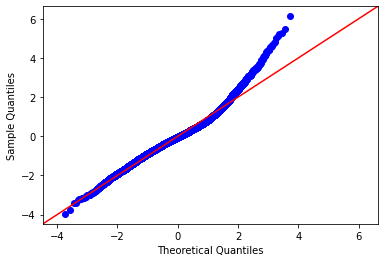

In [85]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

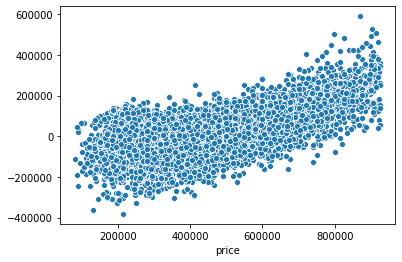

In [86]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_train['price'], model.resid);

In [87]:
# Run a model on the test set

features = '+'.join(X_test.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, X_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     153.5
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:41:48   Log-Likelihood:                -46137.
No. Observations:                3587   AIC:                         9.238e+04
Df Residuals:                    3535   BIC:                         9.270e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.615e+05    2.3e+04    -20.089      0.000   -5.07e+05   -4.16e+05
bedrooms       1.172e+04   2508.292      4.674      0.000    6805.970    1.66e+04
bathrooms      3.638e+04   3721.992      9.773      0.000    2.91e+04    4.37e+04
sqft_lot         -2.5674      0.760     -3.380      0.001      -4.057      -1.078
floors         6603.3850   4247.663      1.555      0.120   -1724.732    1.49e+04
condition      2.506e+04   2645.478      9.471      0.000    1.99e+04    3.02e+04
grade          6.876e+04   3015.040     22.805      0.000    6.28e+04    7.47e+04
sqft_living15    92.8823      4.941     18.798      0.000      83.195     102.570
sales_month   -2054.8390    507.493     -4.049      0.000   -3049.847   -1059.831
house_age      1526.8574     85.674     17.822      0.000    1358.882    1694.833
zipcode_98002 -1.563e+05   1.34e+04    -11.698      0.000   -1.82e+05    -1.3e+05
zipcode_98003 -1.712e+05   1.25e+04    -13.663      0.000   -1.96e+05   -1.47e+05
zipcode_98006  3.972e+04   1.29e+04      3.087      0.002    1.45e+04    6.49e+04
zipcode_98008  5.066e+04   1.44e+04      3.507      0.000    2.23e+04     7.9e+04
zipcode_98023 -1.799e+05   1.02e+04    -17.634      0.000      -2e+05    -1.6e+05
zipcode_98027  3.709e+04   1.59e+04      2.339      0.019    6006.437    6.82e+04
zipcode_98028 -4.111e+04   1.33e+04     -3.083      0.002   -6.73e+04    -1.5e+04
zipcode_98029  4.044e+04    1.3e+04      3.122      0.002     1.5e+04    6.58e+04
zipcode_98030  -1.61e+05   1.32e+04    -12.193      0.000   -1.87e+05   -1.35e+05
zipcode_98031 -1.564e+05   1.37e+04    -11.449      0.000   -1.83e+05    -1.3e+05
zipcode_98033  1.452e+05   1.34e+04     10.802      0.000    1.19e+05    1.72e+05
zipcode_98034  3629.0571   9530.099      0.381      0.703   -1.51e+04    2.23e+04
zipcode_98038 -1.229e+05   9996.595    -12.296      0.000   -1.43e+05   -1.03e+05
zipcode_98042 -1.526e+05   9995.663    -15.262      0.000   -1.72e+05   -1.33e+05
zipcode_98052  4.248e+04   1.08e+04      3.934      0.000    2.13e+04    6.37e+04
zipcode_98053  1.363e+05   1.57e+04      8.706      0.000    1.06e+05    1.67e+05
zipcode_98055 -1.383e+05   1.37e+04    -10.067      0.000   -1.65e+05   -1.11e+05
zipcode_98056 -6.799e+04   1.25e+04     -5.460      0.000   -9.24e+04   -4.36e+04
zipcode_98058 -1.379e+05   1.12e+04    -12.266      0.000    -1.6e+05   -1.16e+05
zipcode_98059 -7.347e+04   1.38e+04     -5.309      0.000   -1.01e+05   -4.63e+04
zipcode_98074  3.376e+04   1.29e+04      2.619      0.009    8484.196     5.9e+04
zipcode_98092 -1.868e+05   1.55e+04    -12.089      0.000   -2.17e+05   -1.56e+05
zipcode_98103  9.633e+04   1.02e+04      9.454      0.000    7.64e+04    1.16e+05
zipcode_98105  1.343e+05   1.72e+04      7.826      0.000    1.01e+05    1.68e+05
zipcode_98106 -5.953e+04   1.15e+04     -5.176   

In [88]:
# Check the mean of residuals

model.resid.mean()

-1.5112857280051372e-07

<Figure size 864x432 with 0 Axes>

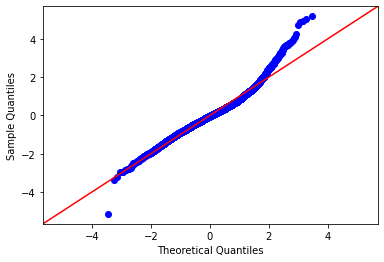

In [89]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

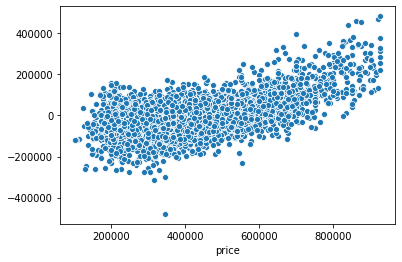

In [90]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_test['price'], model.resid);

In [91]:
# Perhaps log transform? 

# log_names = [f'{column}_log' for column in df_dummies.columns]
# df_dummies_log = np.log(df_dummies)
# df_dummies_log.columns = log_names
# df_dummies_log.head()

In [92]:
# features = '+'.join(df_dummies_log.drop('price_log', axis = 1).columns)
# formula = 'price_log ~' + features
# model = smf.ols(formula, df_dummies_log).fit()
# model.summary()

In [93]:
# Maybe normalize?

# df_dummies_normal = df_dummies.apply(normalize)
# df_dummies_normal.head()

## Interpret

## Conclusion

### Summary
We have now examined the house sale data for King County, Washington in an attempt to determine what potential sellers can do to increase the finale sale price of their home.  While there are many factors to consider when it comes to home value, we were able to use data scrubbing and linear regression models to accurately it down to a few key features that drive the sale price.  

Three important questions answered above are:
  - What are the three most important features to consider in regards to sale price?
  - How much does each feature affect the overall sale price?
  - A third question I haven't thought of yet.
  
We are now able to conclude that sellers should do this thing I'm about to say.  Whatever that may be. 

### Recommendations
Based on the results of this analysis, we have the following recommendations:

### Future Work
With more time, we can do better work and also look at several other factors that could potentially drive the sale price much higher.  These include: 

<b><u> Creating a Pipeline:</b></u> <br>
Creating a pipeline will make this notebook much easier to read as well as make it more readily available to be used again with new data. 

<b><u> Timing: </b></u> <br>  Is there a trend in your neighborhood?  If the market is on the rise in your zipcode, it may be worth waiting til the optimal moment to put the house on the market.

<b><u> Investment Properties: </b></u> <br>  Are there houses in King County that could see a huge return on investment with minor renovations?

<center><i><b> Thank you. </b></i></center>